# Goal 

In this kernel we will consider a few points:
    - 1. How to split to Train/Valid Unbalanced Dataset
    - 2. How to improve score by:
        2.1 Defining weights
        2.2 Changing threshold
        
Dataset used - load_breast_cancer

# Load

In [241]:
%matplotlib inline
from fastai.imports import *
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display
from sklearn import metrics
from sklearn.datasets import load_breast_cancer

from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score

from sklearn.metrics import confusion_matrix

# Model

In [3]:
df=load_breast_cancer()

x=pd.DataFrame(df['data'])
y=pd.DataFrame(df['target'])

x.columns=df['feature_names']
y.columns=['TARGET']

#Unbalanced Dataset
print('Classes_proportion')
y['TARGET'].value_counts()

Classes_proportion


1    357
0    212
Name: TARGET, dtype: int64

In [12]:
#Prepare Train/Valid Set
#can use stratify by defauld it alredy done as well in function

X_train,X_val,y_train,y_val=train_test_split(x,y,test_size=0.17,shuffle=True,random_state=1,stratify=y)

# With test size 17% we have best split - train equal to test
print('Share_0/1_train\n', y_train['TARGET'].value_counts()/len(y_train))
print('Share_0/1_test\n', y_val['TARGET'].value_counts()/len(y_val))

Share_0/1_train
 1    0.627119
0    0.372881
Name: TARGET, dtype: float64
Share_0/1_test
 1    0.628866
0    0.371134
Name: TARGET, dtype: float64


In [14]:
print(X_train.shape)
print(X_val.shape)

(472, 30)
(97, 30)


## Helper


In [246]:
# Function to calculate score (threshold could be changed)
#score - f1_score, roc_auc_score
def thresh_set_score_f1(r1,r2,m,score):
    #m=RandomForestClassifier(random_state=1,oob_score=True)
    m.fit(X_train,y_train.values.ravel())
    pred_p=m.predict_proba(X_val)[:,1]
    pred_thr=[]

    for j in range(r1,r2,1):
        pred_thr=[]
        for i in range(0,len(pred_p)):
                if list(pred_p)[i]>j/100:
                    pred_thr.append(1)
                else:
                    pred_thr.append(0)
        print(j/100)
        print('Score: ', score(y_val['TARGET'],pred_thr,average='weighted'))
        score=score(y_val['TARGET'],pred_thr,average='weighted')
        print('Confusion_matrix_Baseline: \n',confusion_matrix(y_val,m.predict(X_val)))
        return score

# Prediction

In [244]:
#Classify_baseline
m=RandomForestClassifier(random_state=1,oob_score=True)
m.fit(X_train,y_train.values.ravel())
print('--BASELINE_SCORES')
print('OOB_Score no weights:',m.oob_score_)
print('VAL_ROC_AUC no weights:',roc_auc_score(y_val,(m.predict_proba(X_val)[:,1])))
print('VAL_F1:',f1_score(y_val,m.predict(X_val), average='weighted'))
print('Confusion_matrix_Baseline: \n',confusion_matrix(y_val,m.predict(X_val)))

--BASELINE_SCORES
OOB_Score no weights: 0.9661016949152542
VAL_ROC_AUC no weights: 0.9742714025500911
VAL_F1: 0.9381443298969072
Confusion_matrix_Baseline: 
 [[33  3]
 [ 3 58]]


In [232]:
#Search for weights to improve score F1

# better to use valid score not oob to define best parameters

#i=15
#j=3
for i in [15]:
    for j in [3]:

        m=RandomForestClassifier(random_state=1,oob_score=True,class_weight={0:i,1:j})
        m.fit(X_train,y_train.values.ravel())
        print(i)
        print(j)
        #print('OOB_Score no weights:',m.oob_score_)
        #print('TEST_Score no weights:',roc_auc_score(y_test,(m.predict_proba(X_test)[:,1])))
        
        print('F1:',f1_score(y_val,m.predict(X_val), average='weighted'))


15
3
F1: 0.979253171172027


In [245]:
#Improved AUC and F1 scores by defined weights
m=RandomForestClassifier(random_state=1,oob_score=True,class_weight={0:15,1:3})
m.fit(X_train,y_train.values.ravel())
print('--TUNED_CLASS_WEIGHT_SCORES--')
print('OOB_Score weights:',m.oob_score_)
print('VAL_ROC_AUC weights:',roc_auc_score(y_val,(m.predict_proba(X_val)[:,1])))
print('VAL_F1:',f1_score(y_val,m.predict(X_val), average='weighted'))
print('Confusion_matrix_Baseline: \n',confusion_matrix(y_val,m.predict(X_val)))

--TUNED_CLASS_WEIGHT_SCORES--
OOB_Score weights: 0.9576271186440678
VAL_ROC_AUC weights: 0.9842896174863388
VAL_F1: 0.979253171172027
Confusion_matrix_Baseline: 
 [[34  2]
 [ 0 61]]


In [247]:
#model with tunned class_weight
#threshold value - 0.5 is ok!

#weighted F1 with defined weghts not improve score with changing threshold

m=RandomForestClassifier(random_state=1,oob_score=True,class_weight={0:15,1:3})
thresh_set_score_f1(49,51,m,f1_score)

0.49
Score:  0.979253171172027
Confusion_matrix_Baseline: 
 [[34  2]
 [ 0 61]]


0.979253171172027

In [248]:
m=RandomForestClassifier(random_state=1,oob_score=True)

#f1_score
score_F1_bas_thr=thresh_set_score_f1(31,32,m,f1_score)
score_F1_bas_thr=round(score_F1_bas_thr,4)

#roc_auc_score
score_auc_bas_thr=thresh_set_score_f1(31,32,m,roc_auc_score)
score_auc_bas_thr=round(score_F1_bas_thr,4)

0.31
Score:  0.9687709547288212
Confusion_matrix_Baseline: 
 [[33  3]
 [ 3 58]]
0.31
Score:  0.9583333333333333
Confusion_matrix_Baseline: 
 [[33  3]
 [ 3 58]]


In [249]:

m=RandomForestClassifier(random_state=1,oob_score=True)

#f1_score
score_F1_baseline=thresh_set_score_f1(50,51,m,f1_score)
score_F1_baseline=round(score_F1_baseline,4)

#roc_auc_score
score_auc_baseline=thresh_set_score_f1(31,32,m,roc_auc_score)
score_auc_baseline=round(score_F1_baseline,4)

0.5
Score:  0.9381443298969072
Confusion_matrix_Baseline: 
 [[33  3]
 [ 3 58]]
0.31
Score:  0.9583333333333333
Confusion_matrix_Baseline: 
 [[33  3]
 [ 3 58]]


In [250]:
#Model class_w tunned
m=RandomForestClassifier(random_state=1,oob_score=True,class_weight={0:15,1:3})
m.fit(X_train,y_train.values.ravel())

#f1_score
score_F1_class_w=thresh_set_score_f1(50,51,m,f1_score)
score_F1_class_w=round(score_F1_class_w,4)

#f1_score
score_auc_class_w=thresh_set_score_f1(50,51,m,roc_auc_score)
score_auc_class_w=round(score_auc_class_w,4)

0.5
Score:  0.979253171172027
Confusion_matrix_Baseline: 
 [[34  2]
 [ 0 61]]
0.5
Score:  0.9722222222222222
Confusion_matrix_Baseline: 
 [[34  2]
 [ 0 61]]


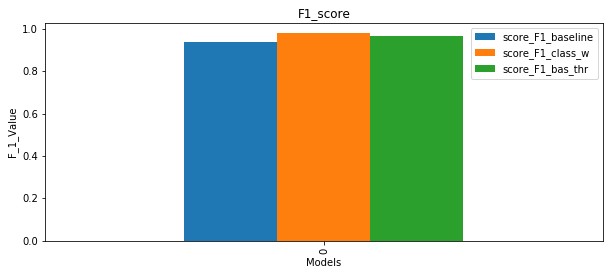

In [251]:
sc=pd.DataFrame([score_F1_baseline,score_F1_class_w,score_F1_bas_thr]).T

sc.columns=['score_F1_baseline','score_F1_class_w','score_F1_bas_thr']
sc.plot(kind='bar',figsize=(10,4))
plt.xlabel('Models')
plt.ylabel('F_1_Value')
plt.legend(loc='upper right')
plt.title('F1_score')
plt.show()

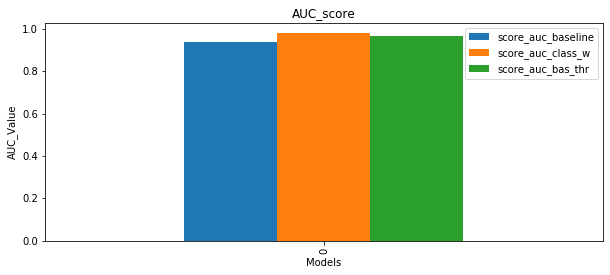

In [252]:
sc=pd.DataFrame([score_F1_baseline,score_F1_class_w,score_F1_bas_thr]).T

sc.columns=['score_auc_baseline','score_auc_class_w','score_auc_bas_thr']
sc.plot(kind='bar',figsize=(10,4))
plt.xlabel('Models')
plt.ylabel('AUC_Value')
plt.legend(loc='upper right')
plt.title('AUC_score')
plt.show()

In [ ]:
# Conclusion

We studied few points:
    - 1. How to split unbalanced df to train/test and check classes proportion
    - 2. How optimize class_weight parameter for RF to have better prediction for unbalanced df (F1_score)
    - 3. How optimize threshold parameter to improve baseline score (F1_score)
    - 4. According to confusion matrix we decreased number of mistakes in prediction from 6 (3+3) to (2).
        However these 2 mistakes still in dangerous area (upper right corner of matrix),
        which means that for 2 people with desease we predicted that they are healthy
        Model tunning required!